In [1]:
# On exécute pip install openpyxl dans le terminal
import pandas as pd
import sqlite3

def création_bdd():
    df1 = pd.read_csv('ValueCo Industrials Europe coverage.csv')
    df2 = pd.read_csv('Controversies Results Feb 24 2025.csv')
    df2_filtré = df2[df2['Client_ID'].isin(df1['isin'])]
    df3 = pd.read_excel('Controversy data documentation.xlsx')
    
    # On vérifie si la colonne 'Factor Column Header' existe dans le DataFrame filtré
    if not df3.empty:
        l_colonnes = df3['Factor Column Header'].tolist()
    else:
        print(f"Aucune ligne trouvée pour aucun type de score")
        return
    
    l_colonnes_complet = ["Client_ID"] + l_colonnes
    
    # On filtre df2 avec les colonnes nécessaires
    df2_filtréx2 = df2_filtré[l_colonnes_complet]
    df2_filled = df2_filtréx2.fillna(0)
    df2_filled = df2_filled.loc[:, ~(df2_filled == 0.0).all()]

    # On calcule les différences de score SI des entreprises entre janvier et mars
    # Chargement des données
    df = pd.read_csv('BQ Results Apr 8 2025.csv')
    df['period'] = pd.to_datetime(df['period'], errors='coerce')
    
    # Dates d'intérêt
    start_date = pd.to_datetime('2024-12-01')
    end_date = pd.to_datetime('2025-03-01')

    # Filtrage par type de score
    df_filtré = df[df['score_kind'] == 'SI']
    
    # Filtrage sur les deux périodes
    df_filtré = df_filtré[df_filtré['period'].isin([start_date, end_date])]
    
    # Pivot pour avoir une colonne par date
    pivot = df_filtré.pivot(index='isin', columns='period', values='consensus')
    
    # Renommer les colonnes pour plus de lisibilité (optionnel)
    pivot = pivot.rename(columns={
        start_date: 'Score_Dec_2024',
        end_date: 'Score_Mars_2025'
    })

    # Calcul de la différence
    pivot['Diff'] = pivot['Score_Mars_2025'] - pivot['Score_Dec_2024']
    
    # Réinitialiser l'index et garder les colonnes souhaitées
    result = pivot.reset_index()[['isin', 'Score_Dec_2024', 'Diff']]

    # Harmonisation du nom de clé
    df2_filled  = df2_filled .rename(columns={'Client_ID': 'isin'})

    # Fusion des bases
    df_merged = pd.merge(df2_filled , result, on='isin')
    return df_merged



In [28]:
import pandas as pd
import statsmodels.api as sm

def reg_lin(df_merged):
    
    x=df_merged.drop(columns=['isin','Diff'])
    # Vérification que X n'est pas vide ou 100% NaN
    if x.dropna(how='all').empty:
        print("❌ Les variables explicatives sont vides ou entièrement nulles.")
        return

    x= sm.add_constant(x)

    y = df_merged['Diff']

    if y.isnull().all():
        print("❌ La variable dépendante 'Diff' est entièrement vide.")
        return

    # Régression linéaire
    model = sm.OLS(y, x).fit()
    print(model.summary())

In [29]:
reg_lin(création_bdd())

                            OLS Regression Results                            
Dep. Variable:                   Diff   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     1.373
Date:                Wed, 14 May 2025   Prob (F-statistic):             0.0757
Time:                        15:17:34   Log-Likelihood:                 721.90
No. Observations:                 255   AIC:                            -1356.
Df Residuals:                     211   BIC:                            -1200.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [2]:
import pandas as pd
import statsmodels.api as sm

def reg_lin_var_rejet():
    # Chargement des données principales
    df_merged= création_bdd()  
    
    x=df_merged.drop(columns=['isin','Diff'])

    # Vérification que X n'est pas vide ou 100% NaN
    if x.dropna(how='all').empty:
        print("❌ Les variables explicatives sont vides ou entièrement nulles.")
        return

    x= sm.add_constant(x)

    y = df_merged['Diff']

    if y.isnull().all():
        print("❌ La variable dépendante 'Diff' est entièrement vide.")
        return

    # Régression linéaire
    model = sm.OLS(y, x)    # Crée le modèle
    results = model.fit() 

    # Liste des variables réellement utilisées (avec estimation de coef)
    used_vars = results.params.index.tolist()

    # Liste des variables que tu as fournies
    all_vars = model.exog_names

    # Variables exclues automatiquement (non identifiées comme estimables)
    excluded_vars = list(set(all_vars) - set(used_vars))

    print("Variables exclues automatiquement :", excluded_vars)  

    # Tableau de résumé simplifié
    summary_df = pd.DataFrame({
    "coef": results.params,
    "pval": results.pvalues,
    "tval": results.tvalues,
    "stderr": results.bse
    })

    # Variables probablement ignorées / redondantes
    mask = (summary_df['pval'] > 0.95) & (summary_df['tval'].abs() < 0.1)
    print(summary_df[mask])

In [3]:
reg_lin_var_rejet()

Variables exclues automatiquement : []
                                    coef      pval      tval    stderr
CONTR_ANTI_COMP_N_TOTAL        -0.000489  0.975198 -0.031126  0.015722
CONTR_COLLECTIVE_BARG_N_SEVERE -0.000450  0.975560 -0.030673  0.014679


In [4]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def reg_ridge_lasso(df_merged):

    X = df_merged.drop(columns=['isin', 'Diff'])
    y = df_merged['Diff']

    if X.dropna(how='all').empty or y.isnull().all():
        print("❌ Données insuffisantes pour la régression.")
        return

    # Imputation et standardisation
    X = X.fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # RidgeCV
    ridge_alphas = np.logspace(-6, 6, 100)
    ridge = RidgeCV(alphas=ridge_alphas, cv=5, scoring='r2').fit(X_scaled, y)
    ridge_cv_score = cross_val_score(ridge, X_scaled, y, cv=5, scoring='r2')

    # LassoCV
    lasso_alphas = np.logspace(-6, 1, 100)
    lasso = LassoCV(alphas=lasso_alphas, cv=5, max_iter=50000, tol=1e-4).fit(X_scaled, y)
    lasso_cv_score = cross_val_score(lasso, X_scaled, y, cv=5, scoring='r2')

    # Résultats Ridge
    print("✅ Ridge Regression")
    print(f"Meilleur alpha : {ridge.alpha_:.6f}")
    print(f"R² entraînement : {ridge.score(X_scaled, y):.4f}")
    print(f"R² validation croisée : {ridge_cv_score.mean():.4f} ± {ridge_cv_score.std():.4f}")

    # Résultats Lasso
    print("\n✅ Lasso Regression")
    print(f"Meilleur alpha : {lasso.alpha_:.6f}")
    print(f"R² entraînement : {lasso.score(X_scaled, y):.4f}")
    print(f"R² validation croisée : {lasso_cv_score.mean():.4f} ± {lasso_cv_score.std():.4f}")

    # Coefficients
    ridge_coef = pd.Series(ridge.coef_, index=X.columns)
    lasso_coef = pd.Series(lasso.coef_, index=X.columns)

    # Coefficients non nuls Lasso
    print("\n📌 Variables sélectionnées par Lasso :")
    print(lasso_coef[lasso_coef != 0].sort_values(ascending=False))

    # Visualisation des coefficients
    plt.figure(figsize=(14, 6))
    ridge_coef.plot(kind='bar', alpha=0.6, label='Ridge', color='cornflowerblue')
    lasso_coef.plot(kind='bar', alpha=0.6, label='Lasso', color='salmon')
    plt.title("Comparaison des coefficients Ridge vs Lasso")
    plt.xlabel("Variables explicatives")
    plt.ylabel("Poids des coefficients")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return ridge, lasso

✅ Ridge Regression
Meilleur alpha : 1232.846739
R² entraînement : 0.0361
R² validation croisée : -0.0391 ± 0.0203

✅ Lasso Regression
Meilleur alpha : 10.000000
R² entraînement : 0.0000
R² validation croisée : -0.0357 ± 0.0185

📌 Variables sélectionnées par Lasso :
Series([], dtype: float64)


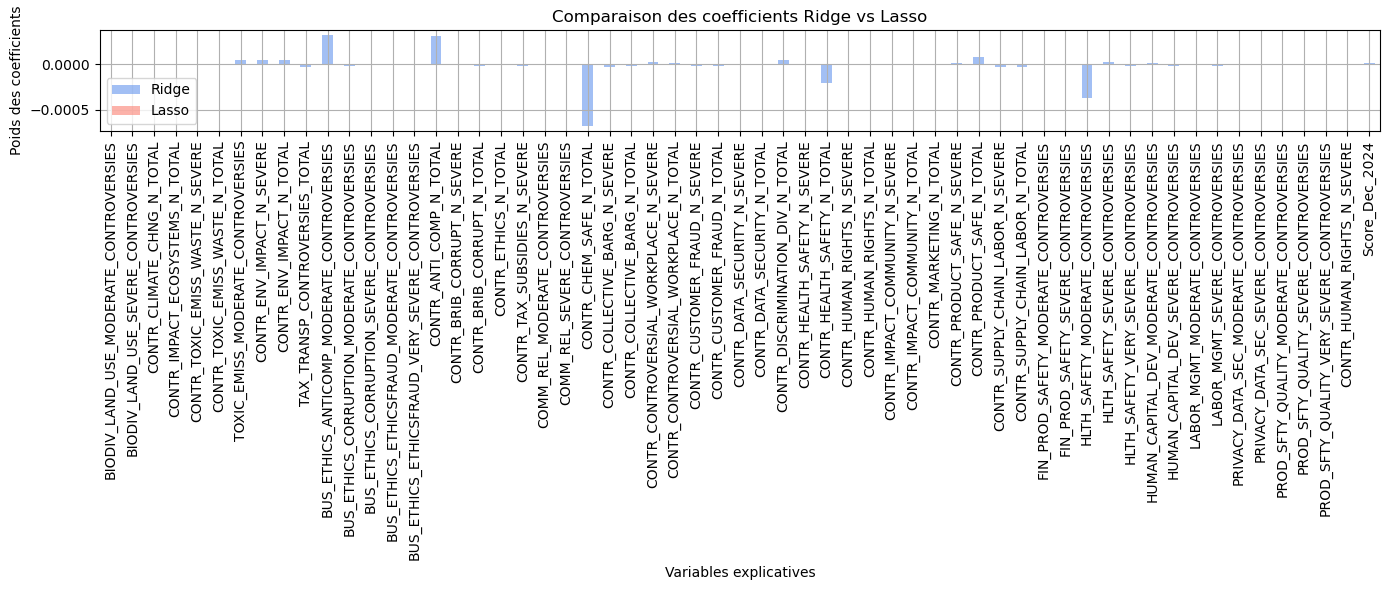

(RidgeCV(alphas=array([1.00000000e-06, 1.32194115e-06, 1.74752840e-06, 2.31012970e-06,
        3.05385551e-06, 4.03701726e-06, 5.33669923e-06, 7.05480231e-06,
        9.32603347e-06, 1.23284674e-05, 1.62975083e-05, 2.15443469e-05,
        2.84803587e-05, 3.76493581e-05, 4.97702356e-05, 6.57933225e-05,
        8.69749003e-05, 1.14975700e-04, 1.51991108e-04, 2.00923300e-04,
        2.65608778e-04, 3.51119173e-0...
        1.62975083e+03, 2.15443469e+03, 2.84803587e+03, 3.76493581e+03,
        4.97702356e+03, 6.57933225e+03, 8.69749003e+03, 1.14975700e+04,
        1.51991108e+04, 2.00923300e+04, 2.65608778e+04, 3.51119173e+04,
        4.64158883e+04, 6.13590727e+04, 8.11130831e+04, 1.07226722e+05,
        1.41747416e+05, 1.87381742e+05, 2.47707636e+05, 3.27454916e+05,
        4.32876128e+05, 5.72236766e+05, 7.56463328e+05, 1.00000000e+06]),
         cv=5, scoring='r2'),
 LassoCV(alphas=array([1.00000000e-06, 1.17681195e-06, 1.38488637e-06, 1.62975083e-06,
        1.91791026e-06, 2.2570197

In [5]:
reg_ridge_lasso(création_bdd())

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def reg_random_forest(df):

    X = df.drop(columns=['isin', 'Diff'])
    y = df['Diff']

    if X.dropna(how='all').empty or y.isnull().all():
        print("❌ Données insuffisantes pour la régression.")
        return

    X = X.fillna(0)

    # Optionnel : standardisation (pas obligatoire pour RF, mais utile pour homogénéiser)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Séparation pour valider les performances
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Modèle Random Forest
    rf = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
    rf.fit(X_train, y_train)

    # Évaluation
    train_score = rf.score(X_train, y_train)
    test_score = rf.score(X_test, y_test)
    cv_scores = cross_val_score(rf, X_scaled, y, cv=5)

    print("✅ Random Forest Regressor")
    print(f"R² entraînement : {train_score:.4f}")
    print(f"R² test : {test_score:.4f}")
    print(f"R² validation croisée : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Importances des variables
    importances = pd.Series(rf.feature_importances_, index=X.columns)
    importances = importances.sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances.values, y=importances.index, palette='viridis')
    plt.title("Importance des variables (Random Forest)")
    plt.xlabel("Importance relative")
    plt.tight_layout()
    plt.show()

    return rf

✅ Random Forest Regressor
R² entraînement : 0.8056
R² test : -0.1625
R² validation croisée : -0.3580 ± 0.4896


/tmp/ipykernel_61576/466697625.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='viridis')


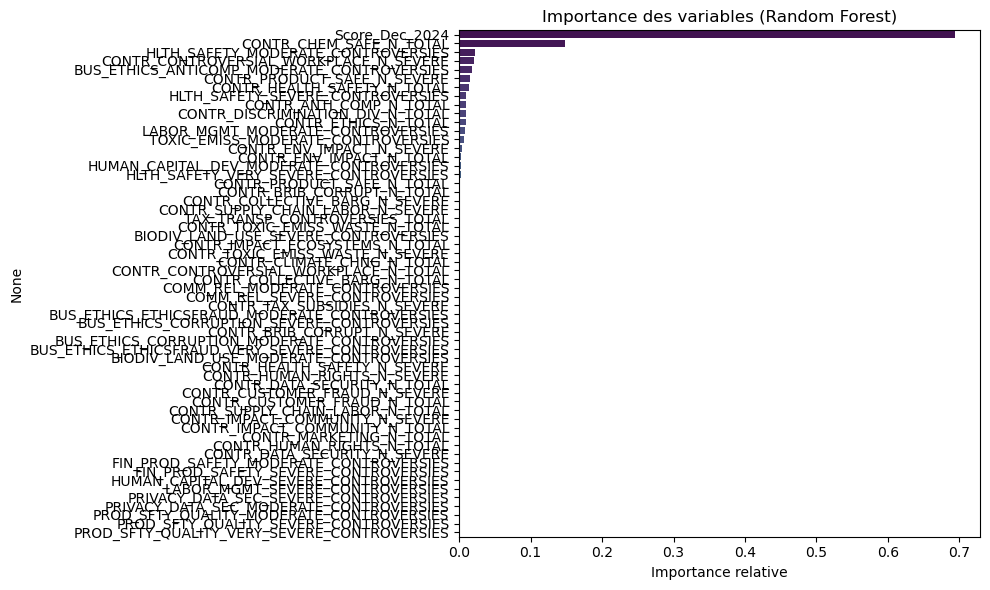

RandomForestRegressor(max_depth=5, random_state=42)

In [34]:
reg_random_forest(création_bdd())

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np

def reg_gradient_boosting(df_merged):

    X = df_merged.drop(columns=['isin', 'Diff']).fillna(0)
    y = df_merged['Diff']

    if X.dropna(how='all').empty or y.isnull().all():
        print("❌ Données insuffisantes.")
        return

    # Standardisation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Split pour évaluation
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Gradient Boosting
    gb=GradientBoostingRegressor(n_estimators=50, max_depth=2, learning_rate=0.05)
    gb.fit(X_train, y_train)

    # Évaluations
    r2_train = gb.score(X_train, y_train)
    r2_test = gb.score(X_test, y_test)
    cv_scores = cross_val_score(gb, X_scaled, y, cv=5, scoring='r2')

    print("✅ Gradient Boosting Regressor")
    print(f"R² entraînement : {r2_train:.4f}")
    print(f"R² test : {r2_test:.4f}")
    print(f"R² validation croisée : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Variables importantes
    importances = pd.Series(gb.feature_importances_, index=df_merged.drop(columns=['isin', 'Diff']).columns)
    importances = importances.sort_values(ascending=False)

    print("\n📌 Top variables importantes :")
    print(importances.head(10))

    return gb, importances

In [36]:
reg_gradient_boosting(création_bdd())

✅ Gradient Boosting Regressor
R² entraînement : 0.6016
R² test : -0.0312
R² validation croisée : -0.2188 ± 0.2168

📌 Top variables importantes :
Score_Dec_2024                                0.858270
CONTR_CHEM_SAFE_N_TOTAL                       0.136168
BUS_ETHICS_ANTICOMP_MODERATE_CONTROVERSIES    0.005522
CONTR_SUPPLY_CHAIN_LABOR_N_TOTAL              0.000035
HLTH_SAFETY_VERY_SEVERE_CONTROVERSIES         0.000004
CONTR_CLIMATE_CHNG_N_TOTAL                    0.000000
CONTR_TOXIC_EMISS_WASTE_N_SEVERE              0.000000
TOXIC_EMISS_MODERATE_CONTROVERSIES            0.000000
CONTR_IMPACT_ECOSYSTEMS_N_TOTAL               0.000000
CONTR_TOXIC_EMISS_WASTE_N_TOTAL               0.000000
dtype: float64


(GradientBoostingRegressor(learning_rate=0.05, max_depth=2, n_estimators=50),
 Score_Dec_2024                                      0.858270
 CONTR_CHEM_SAFE_N_TOTAL                             0.136168
 BUS_ETHICS_ANTICOMP_MODERATE_CONTROVERSIES          0.005522
 CONTR_SUPPLY_CHAIN_LABOR_N_TOTAL                    0.000035
 HLTH_SAFETY_VERY_SEVERE_CONTROVERSIES               0.000004
 CONTR_CLIMATE_CHNG_N_TOTAL                          0.000000
 CONTR_TOXIC_EMISS_WASTE_N_SEVERE                    0.000000
 TOXIC_EMISS_MODERATE_CONTROVERSIES                  0.000000
 CONTR_IMPACT_ECOSYSTEMS_N_TOTAL                     0.000000
 CONTR_TOXIC_EMISS_WASTE_N_TOTAL                     0.000000
 BIODIV_LAND_USE_SEVERE_CONTROVERSIES                0.000000
 TAX_TRANSP_CONTROVERSIES_TOTAL                      0.000000
 BUS_ETHICS_CORRUPTION_MODERATE_CONTROVERSIES        0.000000
 BUS_ETHICS_ETHICSFRAUD_MODERATE_CONTROVERSIES       0.000000
 BUS_ETHICS_CORRUPTION_SEVERE_CONTROVERSIES          0